$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

<img src="../3600.jpg" width=500 />

# Tutorial 3: Convolutional Neural Networks

## Todays Agenda
---

- Convolution and Convolutional layers
- Pooling layers
- Batch Normalization
- Dropout regulatization
- Network architecture
- image classification with CNN
- Residual nets
- reading at home

## imports
---

In [4]:
# Setup
%matplotlib inline
import os
import time
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [5]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')

## Reminders and recaps
---

### Multilayer Perceptron (MLP)

#### Model

<center><img src="resources/mlp.png" width=500 /></center>

Composed of multiple **layers**.

Each layer $j$ consists of $n_j$ regular perceptrons ("neurons") which calculate:
$$
\vec{y}_j = \varphi\left( \mat{W}_j \vec{y}_{j-1} + \vec{b}_j \right),~
\mat{W}_j\in\set{R}^{n_{j}\times n_{j-1}},~ \vec{b}_j\in\set{R}^{n_j}.
$$

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\vec{y}_L^i= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

**Potent hypothesis class**: An MLP with $L>1$, can approximate virtually any continuous function given enough parameters (Cybenko, 1989).

## Limitations of MLPs for image classification

an image is essentially an 2d / 3d array of numbers<br>
<img src="resources/8.png" width="900">


1. Number of parameters increases quadratically with input size <br>
28x28 MNIST image: 784 weights per neuron in the first layer<br>
a 1000x1000x3 color image: 3M weights **per neuron**

Huge number of parameters greatly increases risk of overfitting

  <center><img src="resources/1200px-Overfitting.png" width="400" alt="overfit1"></center>
  

2. highly sensitivity, even for the simplest transformations

<img src="resources/tut_8_alignment3.png" width="600">

<img src="resources/tut_8_alignment4.png" width="600">

### Basic 2D Transformations matematical example

<img src="resources/tut_8_alignment5.png" width="600">


read more about [affine transformations](https://en.wikipedia.org/wiki/Affine_transformation)

One way to deal with the second problem, is to understand the transformation, convolve(?) with a fixed kernel the image
[image processing kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

We still want to use powerful tools on images that can deal with this limitations

## Convolution
---

(first apear in D'Alembert's derivation of Taylor's theorem in Recherches sur différents points importants du système du monde, published in 1754)


<center><img src="resources/Convolution.png" width="800" /></center>

<center><img src="resources/Convolution_of_spiky_function_with_box2.gif" width="800" /></center>

image and gif from [betterexplained.com](http://www.betterexplained.com)



<center><img src="resources/image-2.jpg" width="700" /></center>

just from the algebraic properties, we already gain shift invariant, and homogenues helps us for scale invariance


## Convolutional Layers


1D discrite convolution define as:
$$
\left\{\vec{g}\ast\vec{f}\right\}_j = \sum_{i} g_{j-i} f_{i}.
$$


2D convolution can be defined as:
$$ f[n, m] * g[n,m] = \sum_{k=-\infty}^{\infty}\sum_{l=-\infty}^{\infty} f[k, l]\cdot g[n-k, m-l] $$



Given an input tensor $\vec{x}$ of shape $(C_{\text{in}}, H_{\text{in}}, W_{\text{in}})$,
a convolutional layer produces an output tensor $\vec{y}$ of shape $(C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$,
such that:

$$
\vec{y}^j = \sum_{i=1}^{C_\text{in}} \vec{w}^{ij}\ast\vec{x}^i+b^j;\ j=1,2,\dots,C_\text{out}
$$
is the $j$-th feature map (or channel) of the output tensor $\vec{y}$, the $\ast$ denotes convolution, and $x^i$ is the $i$-th input feature map.


Convolution is a **linear** and **shift-equivariant** operator.

Linear means it can be represented simply as a matrix multiplication.

Shift-equivariance means that a shifted input will result in an output shifted by the same amount.
Due to this property, the matrix representing a convolution is always a **Toeplitz** matrix.

<center><img src="resources/toeplitz.png" width="500" /></center>

### Visual view as a filter base

Imagine sliding the filter along the input and computing an inner product at each point.

<center><img src="resources/1_D6iRfzDkz-sEzyjYoVZ73w.gif" width="700" /></center>

in this example we use 1d image (grayscale) and 1d kernel (or 1 filter) means- the output will be 1d as well. 

as for RGB image, if we each filer will be 3D since the definistion is to find the information from all channels, and we could have more then one filter:

<center><img src="resources/cnn_filters.png" width="900" /></center>


Each 2D slice of an input and output volume is known as **feature map** or a **channel**.

### Hyperparameters & dimentions

Assume an input volume of shape $(C_{\mathrm{in}}, H_{\mathrm{in}}, W_{\mathrm{in}})$, i.e. channels, height, width.
Define,

1. Number of kernels, $ K \geq 1$.
2. Spatial extent (size) of each kernel, $F \geq 1$. 
3. Stride $S\geq 1$: spatial distance between consecutive applications of a kernel.
4. Padding $P\geq 0$: Number of "pixels" to zero-pad around each input feature map.
5. Dilation $D \geq 1$: Spacing between kernel elements when applying to input.

In the following animations, **blue** maps are inputs,
**green** maps are outputs and
the **shaded** area is the kernel with $F=3$.

| $P=0,~S=1,~D=1$ | $P=1,~S=1,~D=1$ | $P=1,~S=2,~D=1$ | $P=0,~S=1,~D=2$ |
|-----------------|-----------------|-----------------| --------------- |
|<img src="resources/no_padding_no_strides.gif" width="250"/>| <img src="resources/same_padding_no_strides.gif" width="250"/> | <img src="resources/padding_strides.gif" width="250"/> | <img src="resources/dilation.gif" width="250"/> |
|simple Convolution |Convolution with padding same|Convolution with stride|Dilated Convolution|

We can see that the second combination, $F=3,~P=1,~S=1,~D=1$, leads to identical sizes of input and output feature maps.

Then, given a set of hyperparameters,

- Each convolution kernel will (usually) be a tensor of shape $(C_{\mathrm{in}}, F, F)$.
- The ouput volume dimensions will be:

  $$\begin{align}
  H_{\mathrm{out}} &= \left\lfloor \frac{H_{\mathrm{in}} + 2P - D\cdot(F-1) -1}{S} \right\rfloor + 1\\
  W_{\mathrm{out}} &= \left\lfloor \frac{W_{\mathrm{in}} + 2P - D\cdot(F-1) -1}{S} \right\rfloor + 1\\
  C_{\mathrm{out}} &= K\\
  \end{align}$$

- The number of parameters in a convolutional layer will be:

$$
\underbrace{K}_{\mathrm{kernels}} \cdot \left(
\underbrace{C_{\mathrm{in}} \cdot F^2}_{\mathrm{kernel\ parameters}} + \underbrace{1}_{\mathrm{bias\ term}}
\right)
$$

**Example**: Input image is 1000x1000x3, and the first conv layer has $10$ kernels of size 5x5.
The number of parameters in the first layer will be: $ 10 \cdot 3 \cdot 5^2 + 10 = 760 $.


**Note** that for tasks like semantic segmentation (that we're going to talk about later in the course) we can also have output dimention higher then the input
by using **Transposed-Convolution** (not actually de-convolution)

<img src="resources/up.gif" width="250"/>

This is also called **fractionally strided convolutions**
note that the name transposed convolution, since we can use the transposed toplitz matrix of conv:
original matrix would be:
<img src="resources/tconv1.jpeg" width="350"/>

transpose conv matrix would be:
<img src="resources/tconv2.png" width="350"/>


### Pytorch `Conv2d` layer example

In [4]:
tf = transforms.Compose([transforms.ToTensor()])
ds_cifar10 = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, transform=tf)

Files already downloaded and verified


In [5]:
# Load first CIFAR10 image
x0,y0 = ds_cifar10[0]

# add batch dimension
x0 = x0.unsqueeze(0)

# Note: channels come before spatial extent
print('x0 shape with batch dim:', x0.shape)

x0 shape with batch dim: torch.Size([1, 3, 32, 32])


In [6]:
# A function to count the number of parameters in an nn.Module.
def num_params(layer):
    return sum([p.numel() for p in layer.parameters()])

Let's create our first conv layer with pytorch:

In [7]:
import torch.nn as nn

# First conv layer: works on input image volume
conv1 = nn.Conv2d(in_channels=x0.shape[1], out_channels=10, padding=0, kernel_size=3, stride=1)

print(f'conv1: {num_params(conv1)} parameters')

conv1: 280 parameters


Number of parameters: $10\cdot(3\cdot3^2+1)=280$

In [8]:
# Apply the layer to an input
print(f'{"Input image shape:":25s}{x0.shape}')

y1 = conv1(x0)
print(f'{"After first conv layer:":25s}{y1.shape}')

Input image shape:       torch.Size([1, 3, 32, 32])
After first conv layer:  torch.Size([1, 10, 30, 30])


In [9]:
# Second conv layer: works on output volume of first layer
conv2 = nn.Conv2d(in_channels=10, out_channels=20, padding=0, kernel_size=6, stride=2)
print(f'conv2: {num_params(conv2)} parameters')

y2 = conv2(conv1(x0))
print(f'{"After second conv layer:":25s}{y2.shape}')

conv2: 7220 parameters
After second conv layer: torch.Size([1, 20, 13, 13])


New spatial extent:

$$
H_{\mathrm{out}} = \left\lfloor \frac{H_{\mathrm{in}} + 2P -F}{S} \right\rfloor + 1
=
\left\lfloor \frac{32 + 2\cdot 0 -6}{2} \right\rfloor + 1
=
14
$$


**Note**: observe that the width and height dimensions of the input image were never specified!
more on the significance of that later.

## Pooling layers
---

In addition to strides, another way to reduce the size of feature maps between the convolutional layers,
is by adding **pooling** layers.

A pooling layer has the following hyperparameters (but **no trainable parameters**):

1. Spatial extent (size) of each pooling kernel, $F \geq 2$. 
1. Stride $S\geq 2$: spatial distance between consecutive applications.
1. Operation (e.g. max, average, $p$-norm)

**Example**: $\max$-pooling with $F=2,~S=2$ performing a factor-2 downsample:

<center><img src="resources/maxpool.png" width="600" /></center>

### Why pool feature maps after convolutions?

- Reduce feature-map size for next layers (sufficient computation, less prun to overfit).

- increase the **receptive field** of each layer faster.

<center><img src="resources/receptive_field2.png" width="400" /></center>

- Receptive field size increases more rapidly if we add pooling, strides or dilation.
- We want successive conv layers to be affected by increasingly larger parts of the input image.
- This allows us to learn a hierarchy of visual features.

<center><img src="resources/feature_hierarchy.png" width="700" /></center>

#### PyTorch `Pool2d` layer example

In [10]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)

print(f'{"After second conv layer:":25s}{conv2(conv1(x0)).shape}')
print(f'{"After max-pool:":25s}{pool(conv2(conv1(x0))).shape}')

After second conv layer: torch.Size([1, 20, 13, 13])
After max-pool:          torch.Size([1, 20, 6, 6])


## Batch normalization
---

 Batch normalization is a technique for improving the speed, performance, and stability of deep neural networks.
- The reasons behind its effectiveness remain under discussion
- It is used to normalize the input layer by adjusting and scaling the activations.
- BN works for all pixels of the feature - channel-wize  ( $\gamma, \beta \in \mathcal{R}^{C} $).

<img src="resources/tut_conv_bn_algo.png" style="height:300px">

### Recap about Regularization

- In ML class, you learned that in some cases, there is a need to put regulatization on the model weights (Lasso, L2 etc..) to ristrict it from reaching a local undesired minima of the loss function.
- In class we talked about the phenomena of over-fitting, that is essentially a model who learned the distribusion of the train set, a little too well.

- We also mentioned in class that accuracy might not be the only thing that's important to us when we make a prediction.<br>

Now we will present a diffrent kind of regularization that is actually part of the network architecture.

## Dropout Regularization
---

* First presented in <a href="http://jmlr.org/papers/v15/srivastava14a.html">Dropout: A Simple Way to Prevent Neural Networks from Overfitting</a>, 2014.
* Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.
* During training, some number of layer outputs (i.e. neurons) are randomly ignored or “dropped out” with some probability $p$. This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer.
* Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.
* Dropout is activated **only during training** (`model.train()`). In test time, it is turned off (`model.eval()`).



Read more - <a href="https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/">A Gentle Introduction to Dropout for Regularizing Deep Neural Networks</a>

<img src="resources/tfdl_0408.png" style="height:300px">
from oreilly.com

## Network Architecture
---

The basic way to build an architecture of a deep convolutional neural net, is to repeat groups of **conv-relu** layers, optionally sprinkle in some **pooling** in between and top it all off with an **FC-softmax** combination.


Why does such a scheme make sense, e.g. for image classification?


:
<img src="resources/arch.png" width="400" />
<img src="resources/VGG.png" width="600" />

- VGG 19 - 16 conv layers and 3 FC layers


In the above image,

- all the **conv** blocks shown are actually **conv-relu** (or some other nonlinearity).
- The repeating **conv-conv-...-pool** blocks are learned, non-linear feature extractors: they learn to detect specific features in an image (e.g. lines at different orientations).
- The pooling controls the receptive field increase, so that more high-level features can be generated by each conv group (e.g. shapes composed from multiple simple lines).
- The **FC-softmax** at the end is just an MLP that uses the extracted features for classification.
- Training end-to-end learns the classifier together with the features!

There are many other things to consider as part of the architecture:
- Size of conv kernels
- Number of consecutive convolutions
- Use of batch normalization to speed up training
- Dropout for improved generalization
- Not using FC layers
- Skip connections (we'll see later)

All of these could be hyperparameters to cross-validate over!

Many different network architectures exist, made famous mainly by repeated improvements on the ImageNet classification challenge since 2012.

<center><img src="resources/net_archs.png" width="1100" /></center>

Notable ImageNet-winning architectures:

- AlexNet, 5 layers (2012): Based on LeNet, deeper, with ReLU, trained with GPUs
- Inception/GoogLeNet, 22 layers (2014): Multiple (small) kernel sizes at same depth
- ResNet, 152 (!) layers (2015): Skip connections

[SOTA image classification on imagenet](https://paperswithcode.com/sota/image-classification-on-imagenet)

### What filters are deep CNNs learning?

CNNs capture hierarchical features, with deeper layers capturing higher-level, class-specific features
(Zeiler & Fergus, 2013).

<center><img src="resources/zf1.png" width="1000"/></center>

This visualization shows patterns which maximally-activate kernels at various layers of a conv net.

### Image classification in pytorch for cifar-10
----

We're going to preform a classification task on CIFAR10 dataset - 60000 32x32 images, balanced between classes with 5k for train and 1k for test for each class
<center><img src="resources/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width="400"/></center>


In [11]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #mean and var for imagenet R.G.B channels
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#tupple of the classes names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
# load dataset
trainset = torchvision.datasets.CIFAR10(
    root='./datasets', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./datasets', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
im shape: torch.Size([3, 32, 32]) and label shape: torch.Size([])


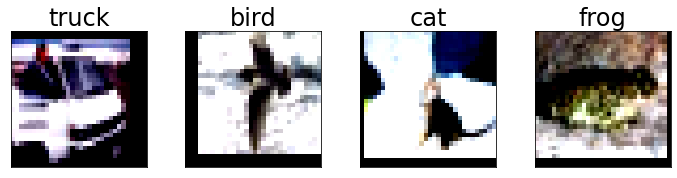

In [29]:
# let's see some of the images
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images[0]))
print(f'im shape: {images[0].shape} and label shape: {labels[0].shape}')

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [13]:
import torch.nn.functional as F
class Vanila_Net(nn.Module):
    def __init__(self):
        super(Vanila_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #in_f, out_f, ker_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class RU_Cifar_CNN(nn.Module):
    """Simple CNN for the CIFAR-10 """
    def __init__(self):
        """contaion the basic blocks of the network"""
        super(RU_Cifar_CNN, self).__init__()

        self.conv_layers = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block 4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(256, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layers(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layers(x)

        return x

In [15]:
vanila = Vanila_Net()
vanila_size = sum([p.numel() for p in vanila.parameters() if p.requires_grad])
print("num trainable weights for vanila net: ", vanila_size)

RU_CNN = RU_Cifar_CNN()
num_trainable_params = sum([p.numel() for p in RU_CNN.parameters() if p.requires_grad])
print(RU_CNN)
print("num trainable weights: ", num_trainable_params)

num trainable weights for vanila net:  62006
RU_Cifar_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, e

In [16]:
# Test forward pass
print('x0 shape=', x0.shape, end='\n\n')
print('CNN(x0)=', RU_CNN(x0), end='\n\n')
print('shape=', RU_CNN(x0).shape)

x0 shape= torch.Size([1, 3, 32, 32])

CNN(x0)= tensor([[-0.1610, -0.0383, -0.0124, -0.0818, -0.1011,  0.1230,  0.1487, -0.0185,
          0.0957,  0.0328]], grad_fn=<AddmmBackward>)

shape= torch.Size([1, 10])


#### Time to train our model


In [17]:
# hyper-parameters
batch_size = 512
learning_rate = 1e-4
epochs = 4

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False)#, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# loss function
loss_fn = nn.CrossEntropyLoss()

# build our model and send it to the device
model = RU_CNN.to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [18]:
vanila.to(device)
optimizer2 = torch.optim.Adam(vanila.parameters(), lr=learning_rate)

In [19]:
def evaluate_accuracy(model, dataloader, device):
    model.eval() #important
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [20]:
# training loop
def train_and_eval(model,optimizer,loss_fn, trainloader,testloader,epochs=20):
    #TRAIN
    for epoch in range(1, epochs + 1):
        model.train()  # put in training mode
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # send them to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs)  # forward pass
            loss = loss_fn(outputs, labels)  # calculate the loss
            # always remember those 3!!
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = evaluate_accuracy(model, trainloader, device)
        test_accuracy, _ = evaluate_accuracy(model, testloader, device)
        epoch_time = time.time() - epoch_time
        
        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # save model - code example, we don't run 20 epocs in this tutorial
        if epoch % 20 == 0:
            print('Saving the model')
            state = {'net': model.state_dict(),'epoch': epoch}
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, './checkpoints/RU_cnn_'+str(epoch)+'.pth')

    
    #EVALUATE
    if os.path.isdir('checkpoints'):        
        state = torch.load('./checkpoints/RU_cnn_20.pth', map_location=device)
        model.load_state_dict(state['net'])
    
    test_accuracy, confusion_matrix = evaluate_accuracy(model, testloader, device)
    print("test accuracy: {:.3f}%".format(test_accuracy))

    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.show()

Epoch: 1 | Loss: 2.2250 | Training accuracy: 24.438% | Test accuracy: 26.430% | Epoch Time: 33.10 secs
Epoch: 2 | Loss: 1.9858 | Training accuracy: 29.080% | Test accuracy: 31.270% | Epoch Time: 32.86 secs
Epoch: 3 | Loss: 1.8926 | Training accuracy: 32.338% | Test accuracy: 34.950% | Epoch Time: 32.87 secs
Epoch: 4 | Loss: 1.8241 | Training accuracy: 33.952% | Test accuracy: 36.850% | Epoch Time: 32.79 secs
test accuracy: 36.850%


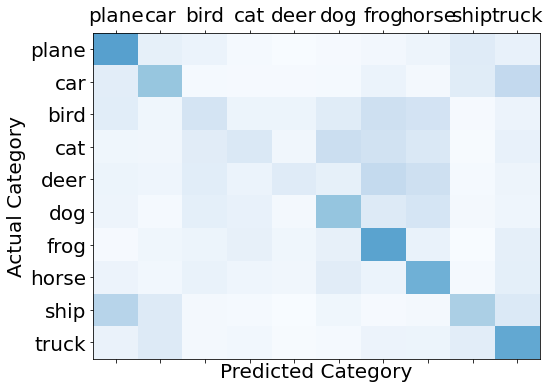

In [21]:
train_and_eval(vanila,optimizer2,loss_fn, trainloader,testloader,epochs=epochs)

Epoch: 1 | Loss: 1.7166 | Training accuracy: 49.808% | Test accuracy: 50.680% | Epoch Time: 40.74 secs
Epoch: 2 | Loss: 1.2440 | Training accuracy: 57.542% | Test accuracy: 58.740% | Epoch Time: 40.90 secs
Epoch: 3 | Loss: 1.0336 | Training accuracy: 65.544% | Test accuracy: 66.840% | Epoch Time: 40.72 secs
Epoch: 4 | Loss: 0.9094 | Training accuracy: 67.610% | Test accuracy: 68.710% | Epoch Time: 40.71 secs
test accuracy: 68.710%


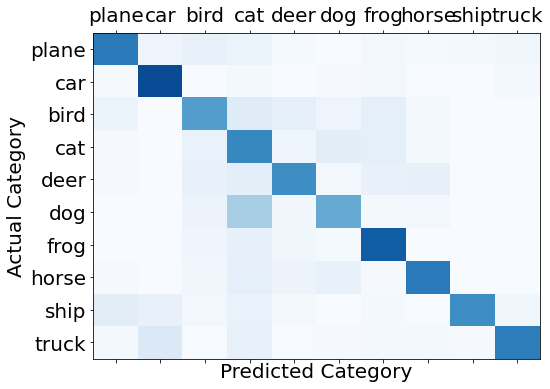

In [22]:
train_and_eval(RU_CNN,optimizer,loss_fn, trainloader,testloader,epochs=epochs)

## Residual Networks
---

We talked about deeper networks to create a deeper receptive field.
However, is **deeper** always mean **better**?

<center><img src="resources/deeper_meme.jpeg"/></center>


In theory, adding an addition layer as idendity should provide the same accuracy as before

In practice we have two major problems:

1. vanishing gradients (very long chain of partial derivitivs)
2. Large parameter space is hard to optimize

<center><img src="resources/plain-networks-training-results-770x272.png" width="600"/></center>

I.e., even if the same solution (or better) exists, SGD-based optimization can't find it. **Optimization error** increased with depth.<br>
(the drop happen because of learning rate scheduler)

ResNets attempt to address these issues by building a network architecture composed of convolutional blocks with added **shortcut-connections**:

<center><img src="resources/resnet_block2.png" width="800"/></center>

(Left: basic block; right: bottleneck block).

resnet images from [neurohive](https://neurohive.io/en/popular-networks/resnet/)

Here the weight layers are `3x3` or `1x1` convolutions followed by batch-normalization.

**Why do these shortcut-connections help?**

These shortcuts create two key advantages:
- Allow gradients to flow freely backwards
- Each block only learns the "residual mapping" - some delta from the identity mapping (easier to optimize)

Implementation with guidance in your homework :)

## Further reading
---

## Batch Norm extention
---

recall for the BN algorithm

<img src="resources/tut_conv_bn_algo.png" style="height:300px">

Now let's try to understand how it looks like in the prespective of training and inference:

in traning, we take a batch
<img src="resources/bn1.png" style="height:500">

the momentum $\alpha = 0.9$ and epsilon is 1e-5 to avoid dev by 0


for each epoch:
- step 1: fetch a batch of samples ($M x F$)
- calculate $(\mu,\sigma) \in R^F$
- Normelize the batched data
- scale with $\gamma and \beta$, both $\in R^F$
- calculate moving avarage,for the set $(\mu,\sigma)$  with momentum. 


<img src="resources/bn2.png" style="height:500px">

The inovative idea is that we don't only want features to be normelized, but we want to let the network learn, how to choose the right normal distribution for the data.

as for inference:
<img src="resources/bn2inf.png" style="height:500">
(images from Ketan Doshi blogpost)

The original idea behind it was to reduce **Internal Covariate Shift**<br>
waving hand explanation is that actually if we learn the shift of the distribution of the data, we can have more accurate estimation of the real data that will come later (that we don't actually know how to normelize by latent space, just the input)<br>

then came a paper by MIT that contredict this idea and suggest that batch norm help for **Loss and Gradient Smoothening**
thus the learning process is easier...<br>


if you want to read more you can read the [original BN paper](https://arxiv.org/pdf/1502.03167.pdf)
and [MIT paper](https://arxiv.org/pdf/1805.11604.pdf)

i also add the blogpost in the links below, if you want to get the intuision without reading the papers...

## visuallization
---

We saw before how features looks like, let's see our network filters and features
for that we're going to load VGG16 model, pre-trained on imagenet dataset (1000 classes)

In [6]:
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True).to(device)
model.eval();

1000 classes is a lot to memories by Heart...
we will use a json file that has all the labels

In [7]:
import json
with open('resources/Imagenet_labels.json') as f:
    labels = json.load(f)
    
class_id_to_label = lambda i : labels[i]

Now we can plot the weights and features of the network
Lets start with the weights:

In [8]:
# functions to visualize the kernels
  
def plot_filters_single_channel(t):
    
    # kernels depth * number of kernels
    nplots = t.shape[0] * t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots // ncols
    # convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    # looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    
def plot_weights(model, layer_num):
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    # checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data.cpu()

        plot_filters_single_channel(weight_tensor)
    else:
        print("Can only visualize layers which are convolutional")

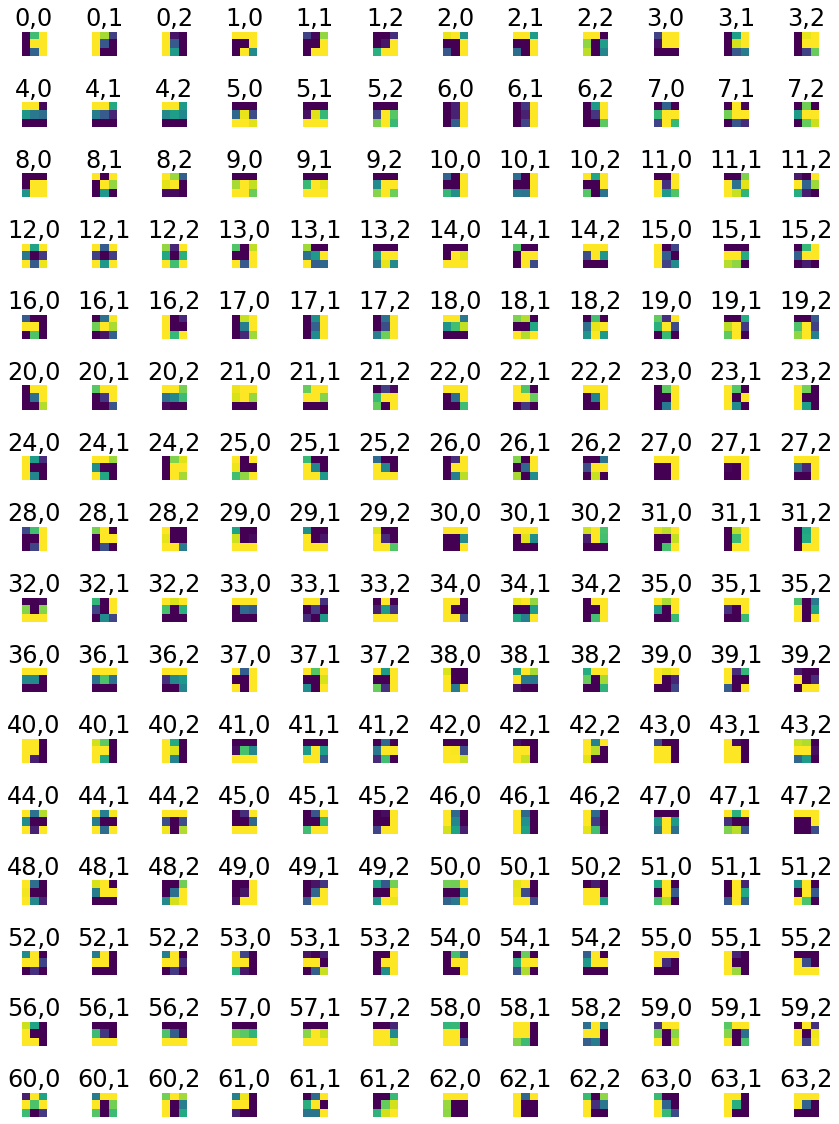

In [9]:
plot_weights(model, 0)

as you can see the 3x3 size, this is our filters...<br>
now let's see how the features looks like in difrrent levels of the network<br>
code from https://github.com/sar-gupta/convisualize_nb/blob/master/cnn-visualize.ipynb

In [10]:
# helper functions, by Tal Daniel
from PIL import Image
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image


def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return index.item() 
    
def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    return image

Pembroke Welsh Corgi


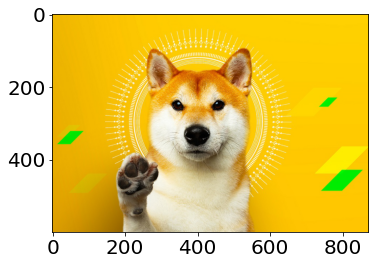

In [11]:
doge = load_image("./resources/DOGE.jpg");
norm_doge = normalize(doge, device)
print(class_id_to_label(predict(norm_doge, model)))

Now let's look at all the features at a specific layer, and see what we've learned:

In [12]:
def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure(figsize=(30, 30))

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)
        imgplot = ax.imshow(filters[i],cmap='hot')
        ax.set_axis_off()
    plt.tight_layout()

<ipython-input-12-fc3209588529>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)


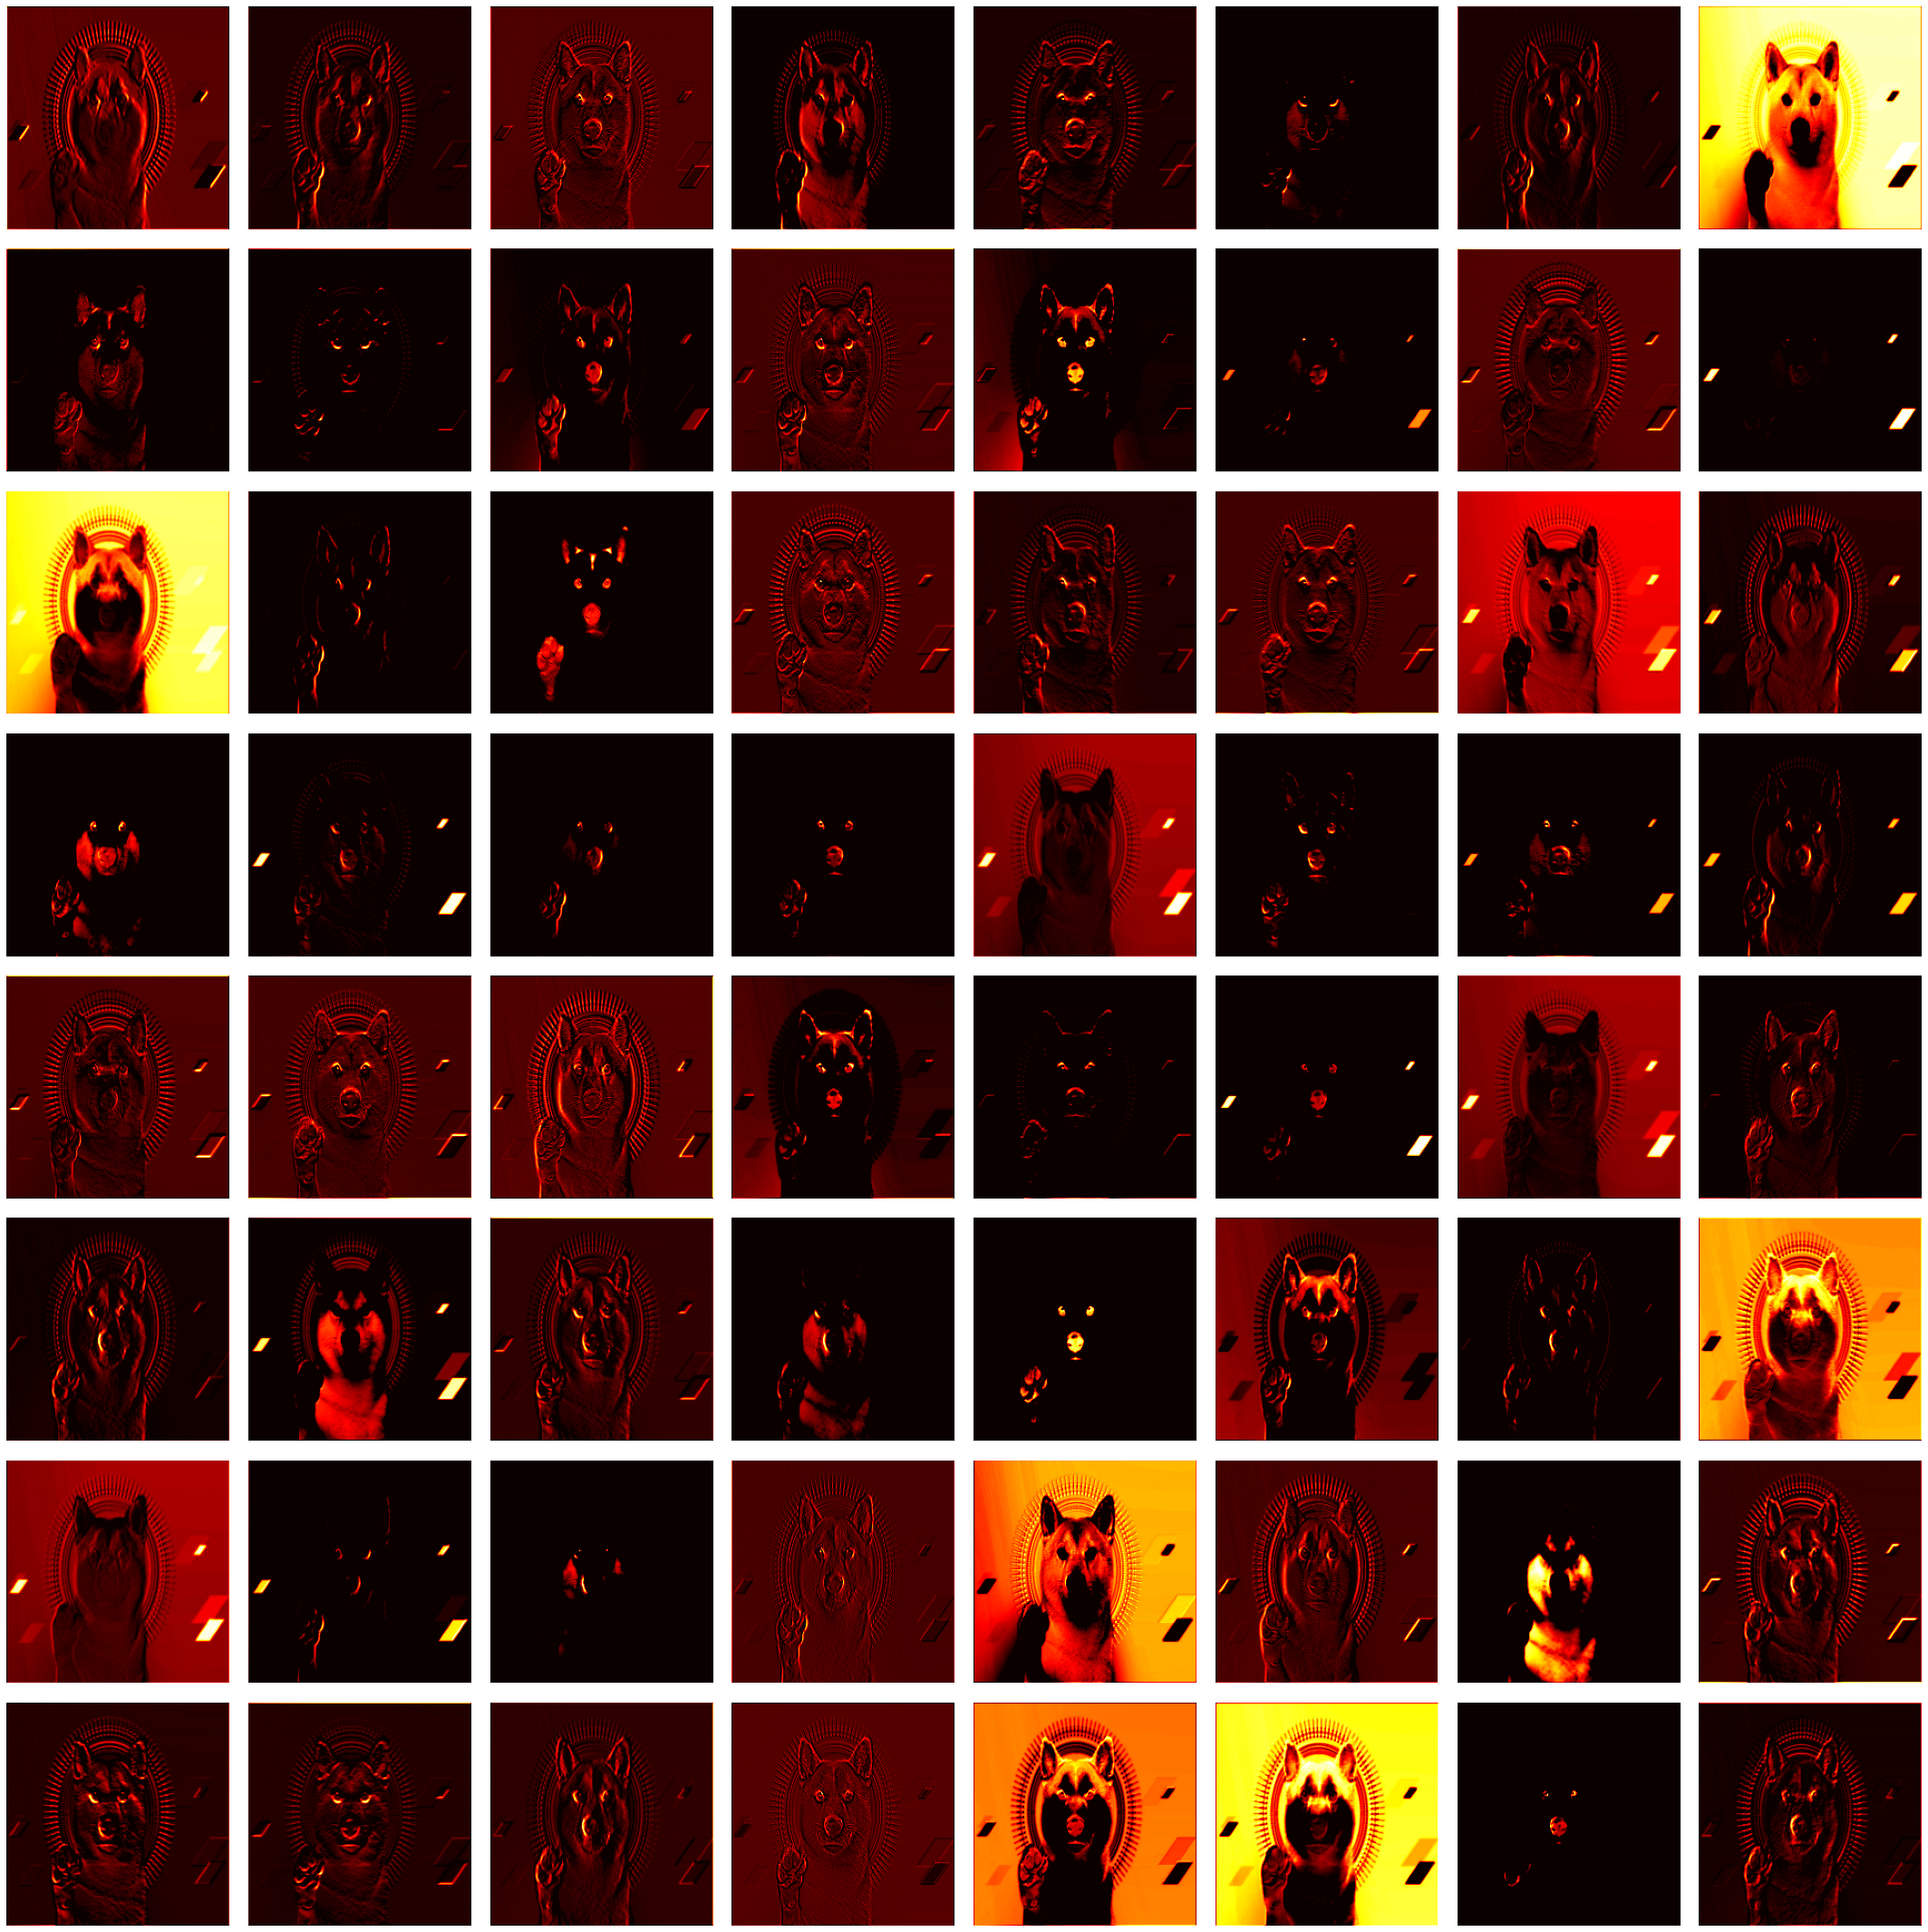

In [13]:
filter_outputs(norm_doge, model, 0)

<ipython-input-12-fc3209588529>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)


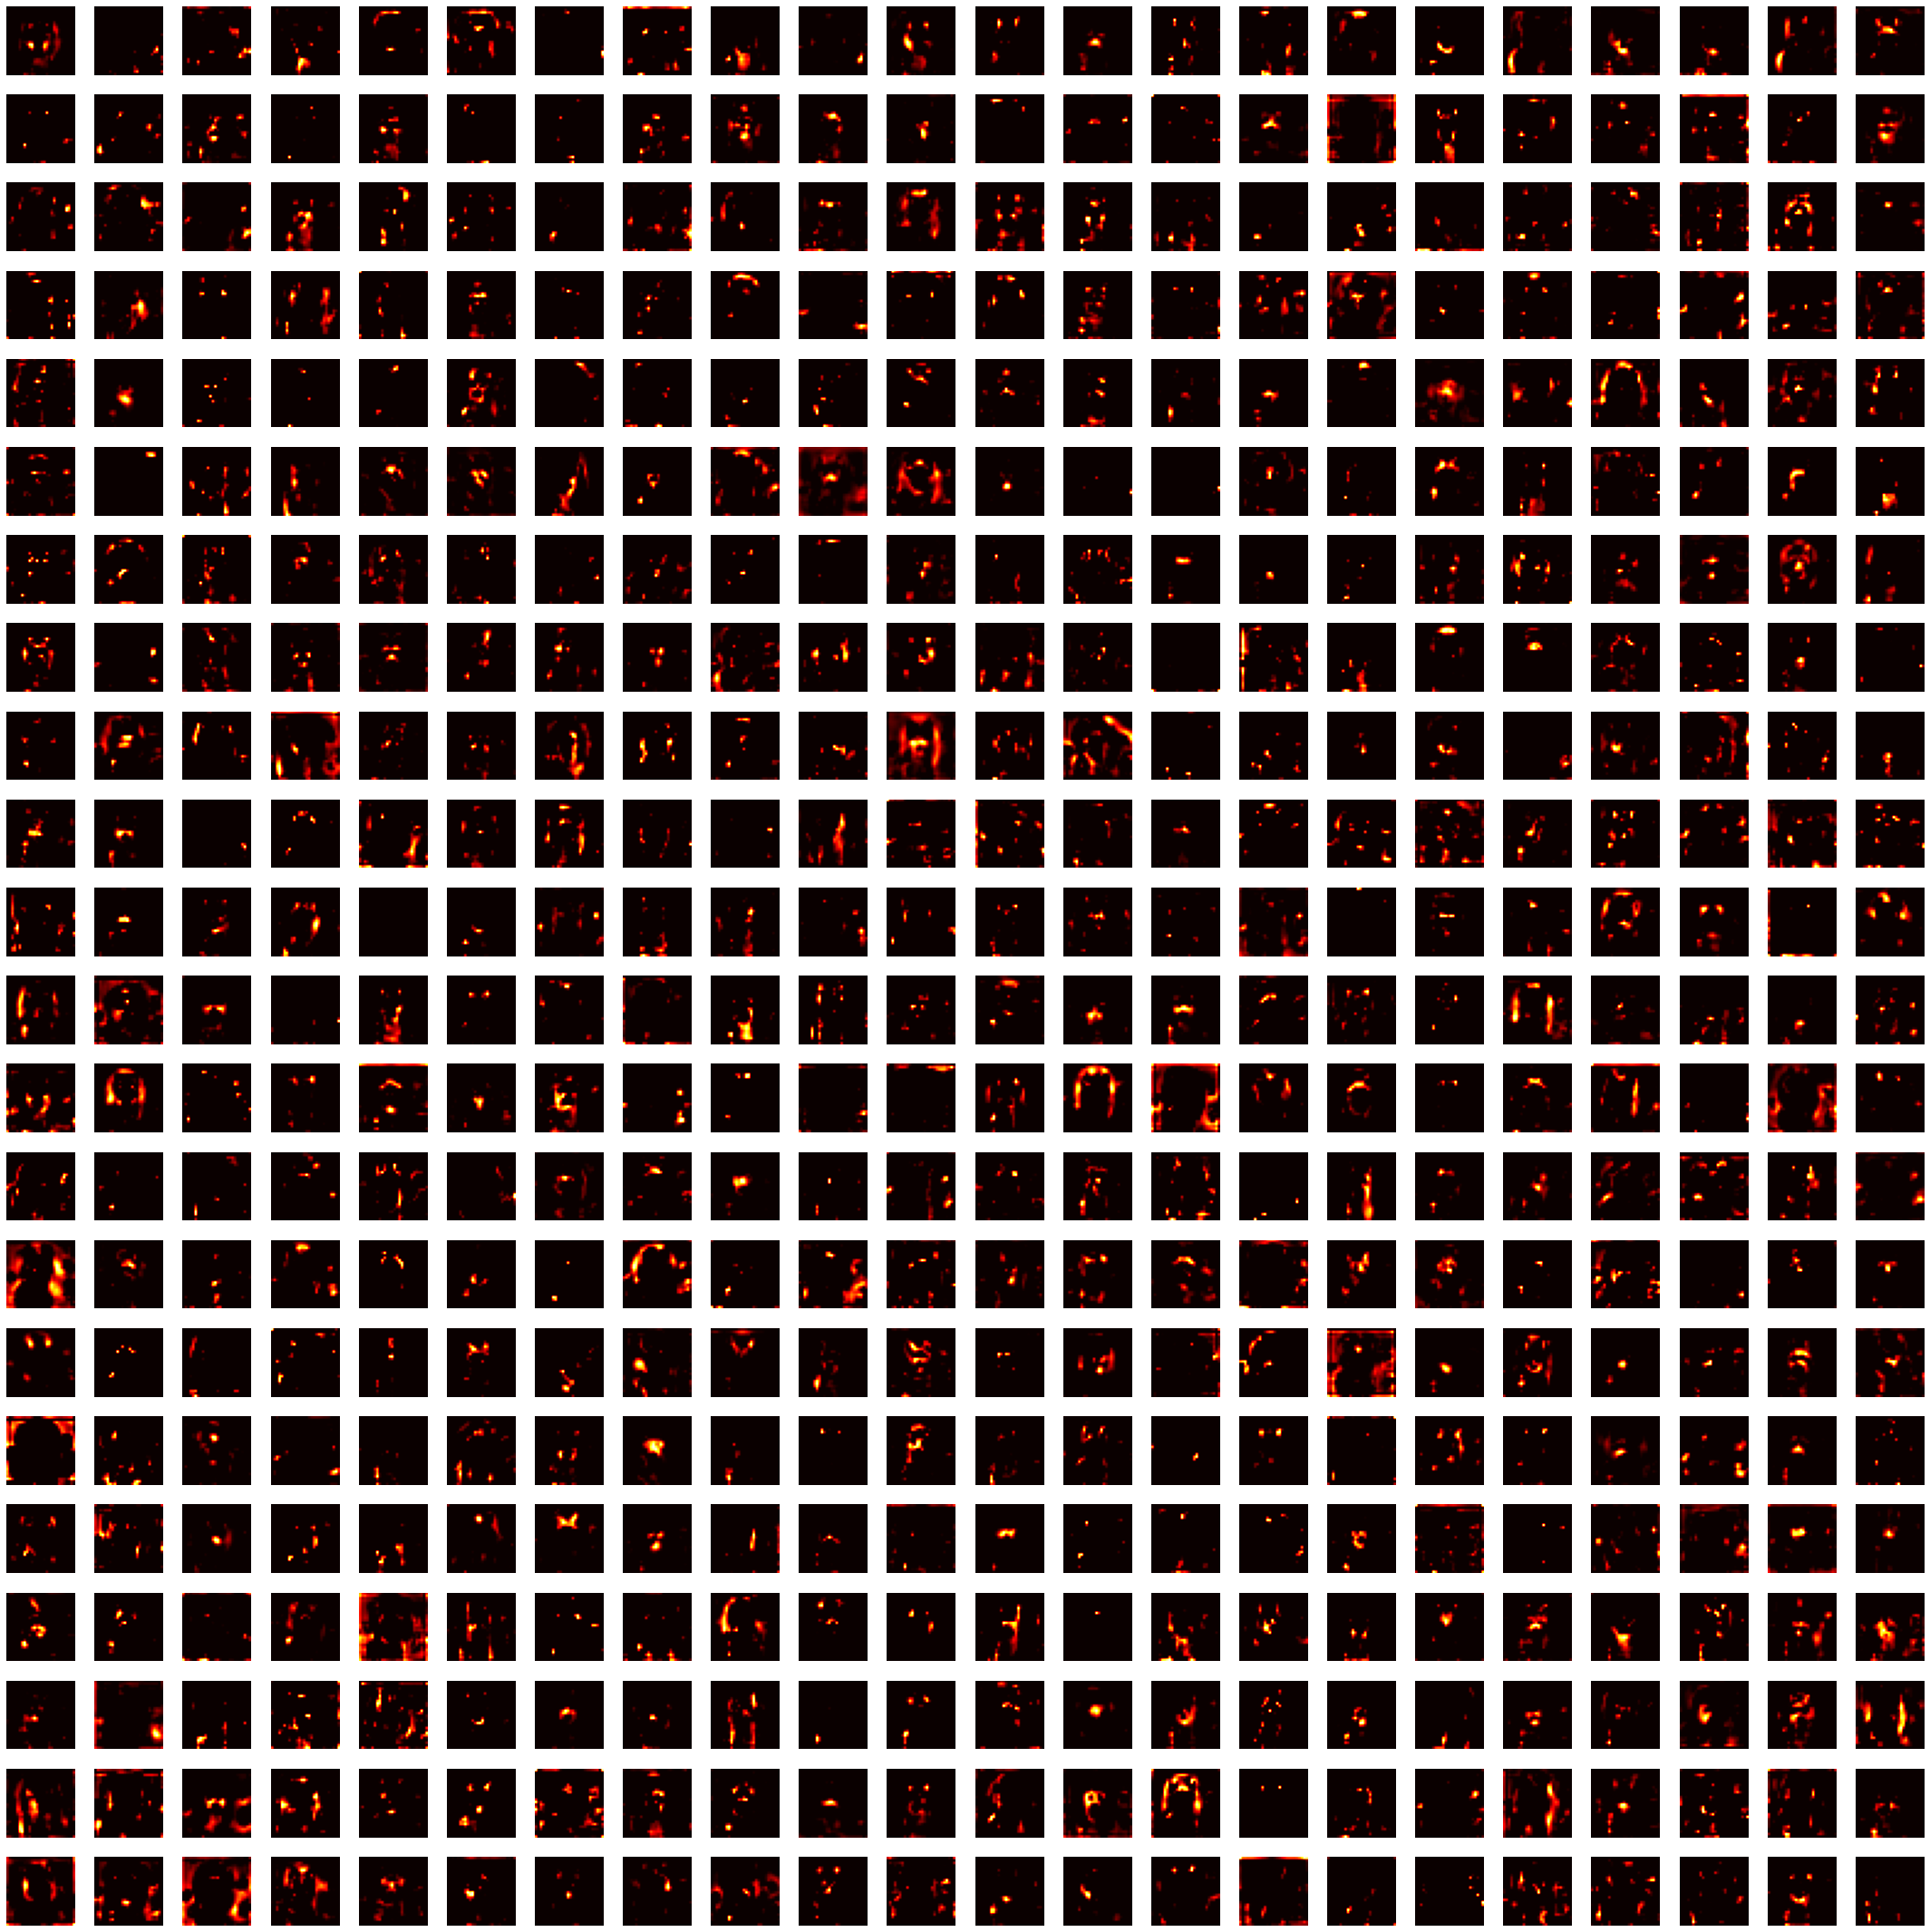

In [14]:
filter_outputs(norm_doge, model, 22)

Note that the 22nd layer learn features that are intuitive to learn with (eyes, ears and so on) while the low level features might be less intuitive, but help us to hirarcally build the high level features

### Inception Network
---

Solving the vanishing gradients problem with ResNet was an awsome boost for Imagenet classification.

However, it came with a cost...

if VGG has 16 or 19 layers, common resnet has 50 layers or more!

deep networks cost a lot of computational time and hardwere for training and inference.

that's why google invented the Inception network, the first Inception based network also call GoogLeNet

<center><img src="resources/comp.png" width="600"/></center>

As you can see above, the network did not overcome the ResNet, but used much less parameters and much less Float Operations! (this order of magnitude worth a lot of money)

The basic idea is to have blocks that have the residual, but also use 1x1 conve to reduce the parameters, and have diffrent convolutions in parellal to capture spatial information in same dept features better.

<center><img src="resources/inc.png" width="600"/></center>


Until This day, you'll see this implementation in the industry in a lot of products, like the MobileNet (also by google) that is simply not SOTA but comparable results achiver with much faster inference time

one important work called googlenet (guess by who...)

you can read [the paper](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf) 

The idea is extention of resnet, but besides of bottleneck skip (1x1 conv), there are some convolutions in parellal and we can fetch features in diffrent shapes at the same lever of the network.<br>
in other words, the receptive field is diffrent for each trajectory and thus we can create more intresting features with less levels.

the series of papers called inceptionV2,v3 and V4...

one of the intresting progress they made with the years is to use non-sqares convolutions.
in [Inception V4](https://arxiv.org/pdf/1602.07261.pdf)

they use 1xA, Ax1 where A is diffrent size, and reduce the number of parameters sagnificantly, so you can have a deeper model with less parameters.

<center><img src="resources/inc4.PNG" width="600"/></center>

for example, and the network compose from layers like that:

<center><img src="resources/inc41.PNG" width="600"/></center>




---
We just learned a lot about CNNs and about how good of a tool it is.

Now we'll show few challenges that we need to know and try to deal with

#### adverserial attacks

networks provide a prediction score for all classes and choose the hightes scored one

* black box attack: small pertubations or added noise to the input image can change the prediction entierly.
* white box attack: with knowledge about the network weaknesses, we can change few neurons or the input to the network in an harmfull way.

here are some examples for an attack preformed by software and by printing a sticker:

<center><img src="resources/adversarial_img_1.png" width="800"/></center>
<center><img src="resources/Adversarial_attacks_02.png" width="800"/></center>

and you can read much more about it in the links provided below

#### inherant networks biases

Remember the first class? we talked about compass and about fairness.

Then we didn't know the Deep learning tools so well, but we talked about fairness that can come from the data.
It turns out that CNNs (and DNNs in general) suffer from bias even when the classes are balanced or when we think that we balanced the representation in the data

<center><img src="resources/resnet prediction.PNG" width="800"/></center>

There is a major research in this subject, however there is no simple solution and engneers need to work hard all over to find the cause for models biases.

 [ConvNets and ImageNet Beyond Accuracy: Understanding Mistakes and Uncovering Biases](https://arxiv.org/abs/1711.11443)

### disclaimer

this was just few of the active problems with image classification (that shared with other fields).

the fields of interpretability of deep learning, as well as deep models uncertainty are floating with hundreds of research papers every year

personaly i belive that we have much more to learn and you can dig online and share with your friends via piazza

#### Thanks!

## Links
---

**convolutions**<br>
[Convolution explained](https://betterexplained.com/articles/intuitive-convolution/)<br>
[video of deep nn in torch](https://www.youtube.com/watch?v=_H3aw6wkCv0&ab_channel=PyData)<br>

**dropout**<br>
[intro to dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)


**batch normalization**<br>
[A Gentle Introduction to Batch Normalization for Deep Neural Networks](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
[Why BatchNorm Works](https://towardsdatascience.com/batch-norm-explained-visually-why-does-it-work-90b98bcc58a0) 


**resnet**<br>
[resnet short overview](https://neurohive.io/en/popular-networks/resnet/)

**Inception**<br>
[Deep Learning in the Trenches: Understanding Inception Network from Scratch](https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/)

**adverserial attacks**<br>
[How to confuse antimalware neural networks](https://securelist.com/how-to-confuse-antimalware-neural-networks-adversarial-attacks-and-protection/102949/)<br>
[Attacking Machine Learning with Adversarial Examples](https://openai.com/blog/adversarial-example-research/)<br>
[What Is Adversarial Machine Learning? Attack Methods in 2021](https://viso.ai/deep-learning/adversarial-machine-learning/)<br>
[Understanding Adversarial Attacks on Deep Learning Based
Medical Image Analysis Systems](https://arxiv.org/pdf/1907.10456.pdf)<br>

**bias**<br>
[Bias in face recognition](https://towardsdatascience.com/bias-in-machine-learning-how-facial-recognition-models-show-signs-of-racism-sexism-and-ageism-32549e2c972d)<br>


## Credits
---

This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
To re-use, please provide attribution and link to the original.

This notebook is inspired by tutorials given by [Aviv Rosenberg](https://avivr.net) and [Tal Daniel](https://www.linkedin.com/in/tal-daniel-2b919513b/)  .<br>


Some images in this tutorial were taken and/or adapted from the following sources:

- Sebastian Raschka, https://sebastianraschka.com/
- Deep Learning, Goodfellow, Bengio and Courville, MIT Press, 2016
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
- Deep Learning with Python, Francios Chollet, Manning 2018
- Stanford cs231n course notes by Andrej Karpathy
- https://github.com/vdumoulin/conv_arithmetic
- Long, J., Shelhamer, E., & Darrell, T. (2015). Fully convolutional networks for semantic segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition.
- Canziani, A., Paszke, A., & Culurciello, E. (2016). An analysis of deep neural network models for practical applications.
- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition.
- A Comprehensive Introduction to Different Types of Convolutions in Deep Learning, Kulun Bai